In [83]:
using Revise # Run this first, if you intend to develop the package

In [3]:
# unnecessary if you follow README
# using Pkg
# Pkg.activate("../QControl")
# Pkg.instantiate()

# Imports

In [4]:
using QControl

In [5]:
const QC = QControl;

In [6]:
using QuantumOptics
import PyPlot as plt
using Plots; pyplot()
using Altro
using ForwardDiff
using LinearAlgebra
using SparseArrays
using RobotDynamics
using TrajectoryOptimization
using StaticArrays
using ForwardDiff
using FiniteDiff
using JLD2
const TO = TrajectoryOptimization
const RD = RobotDynamics
;

# Cavity-Qubit System Setup

In [7]:
# Define bases for cavity (Fock) and atom (Spin-1/2)
const N_CAVITY = 10
const N_QUBIT = 2
const N_FULL = N_CAVITY*N_QUBIT

bq = SpinBasis(1//2)
bc = FockBasis(N_CAVITY - 1)
bfull = bc ⊗ bq
DAC_time_resolution = 1 # ns


# constants (in GHz = cycles / ns)
α = .4
K = 1e-5
χ = 2e-3
D = 1e-3

# operators
a = destroy(bc) ⊗ one(bq)
σx = one(bc) ⊗ sigmax(bq)
σ⁻ = one(bc) ⊗ sigmam(bq) # up -> down, equivalent to creation op
ad = dagger(a)
σ⁺ = dagger(σ⁻)

# base hamiltonian
H₀ = (α/2) * σ⁻ * σ⁻ * σ⁺ * σ⁺
H₀ += (K/2) * ad * ad * a * a
H₀ += χ * ad * a * σ⁻ * σ⁺
H₀ *= 2*π
Hcs = [2*π*D*σx, 2*π*D*(a+ad)];

In [8]:
# binomial code
binomial = Dict("z+" => normalize(fockstate(bc,0) + fockstate(bc,4)), "z-" => fockstate(bc, 2))
binomial["x+"] = normalize(binomial["z+"] + binomial["z-"])
binomial["x-"] = normalize(binomial["z+"] - binomial["z-"])
binomial["y+"] = normalize(binomial["z+"] + im*binomial["z-"])
binomial["y-"] = normalize(binomial["z+"] - im*binomial["z-"])
;

In [63]:
# states
ψi = [fockstate(bc, 0) ⊗ spinup(bq)]
ψt = [binomial["x-"] ⊗ spinup(bq)]
;

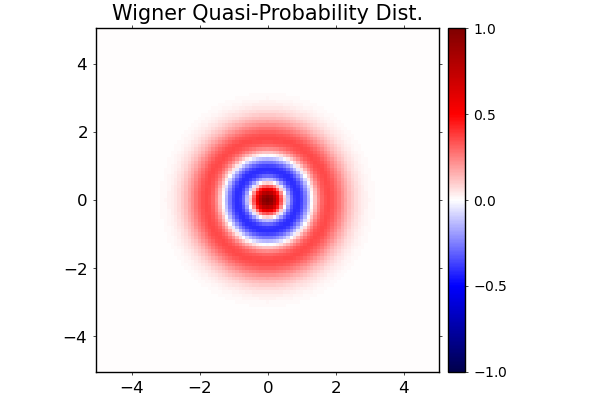

In [121]:
plot_wigner(binomial["z-"])

# Generate Dynamics and Objective

In [65]:
RD.state_dim(::QC.QuantumState), RD.control_dim(::QC.QuantumState), dynamics_func, ψi_state, ψt_state = QC.gen_LQR_params(bfull,H₀, Hcs, ψi, ψt)
RD.dynamics(qs::QC.QuantumState,x,u) = dynamics_func(qs::QC.QuantumState,x,u)
;

In [66]:
model = QC.QuantumState()
state_dim = RD.state_dim(model)
control_dim = RD.control_dim(model)

N = 1001 # number of time steps
tf = 1000.0 # ns, total time
dt = tf / (N-1) # time step

obj = gen_default_objective(state_dim, control_dim, ψt_state; N=N, tf=tf, R_scale=0.0001)

Objective

# Add Constraints

In [67]:
# Add in normalization constraint and goal constraint
cons = ConstraintList(state_dim, control_dim, N)
normcon = NormConstraint(state_dim, control_dim, 1.0, Equality(), :state)
add_constraint!(cons, normcon, N)

goalcon = GoalConstraint(ψt_state)
add_constraint!(cons, goalcon, N)

# Create Problem and Solver

In [68]:
prob = Problem(model, obj, ψi_state, tf, xf=ψt_state, integration=RD.RK4(model));#, constraints=cons);

In [69]:
initial_controls!(prob, [@SVector rand(control_dim) for k = 1:N-1])
rollout!(prob)   # simulate the system forward in time with the new controls

In [70]:
# Set up solver options
opts = SolverOptions()
opts.cost_tolerance = 1e-8

# Create a solver, adding in additional options
solver = ALTROSolver(prob, opts, show_summary=true);

# Solve

In [71]:
solve!(solver);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 203
    Solve Time: 265157.66748 (ms)

  Covergence
    Terminal Cost: 0.01601659775891573
    Terminal dJ: 9.599727880671427e-9
    Terminal gradient: 0.0006971093510643438
    Solve Status: SOLVE_SUCCEEDED


In [72]:
status(solver)

SOLVE_SUCCEEDED::TerminationStatus = 2

In [73]:
println("Number of iterations: ", iterations(solver))
println("Final cost: ", cost(solver))
println("Final constraint satisfaction: ", max_violation(solver)) #TODO: is 1 good??

Number of iterations: 203
Final cost: 0.01601659775891573
Final constraint satisfaction: 1.0


# Save and Load Data

In [84]:
# save data (uncomment to save)
file_label = "data/vac_to_binomial_z_plus"
# save_solver_data(solver, label=file_label)

"data/vac_to_binomial_z_plus"

In [85]:
# load data
data = load_solver_data(string(file_label, ".jld2"))

Dict{String, Vector} with 2 entries:
  "U" => SVector{4, Float64}[[-0.26573, 0.119792, 0.0047946, 0.504273], [-0.265…
  "X" => SVector{40, Float64}[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0…

# Parse Data

In [113]:
X = data["X"]    # alternatively states(prob)
U = data["U"]   # alternatively controls(prob)
Ucv = controls_to_amplitudes(U)
pulse_indx = 2
Urv = map(cv -> real(cv[pulse_indx]), Ucv)
Uiv = map(cv -> imag(cv[pulse_indx]), Ucv)
Uav = map(cv -> norm(cv[pulse_indx]), Ucv)
Xqv = states_to_kets(X, bfull)
;

In [114]:
fidt = map(qv -> abs(dagger(qv)*(binomial["z+"] ⊗ spinup(bq)))^2, Xqv);

# Plots

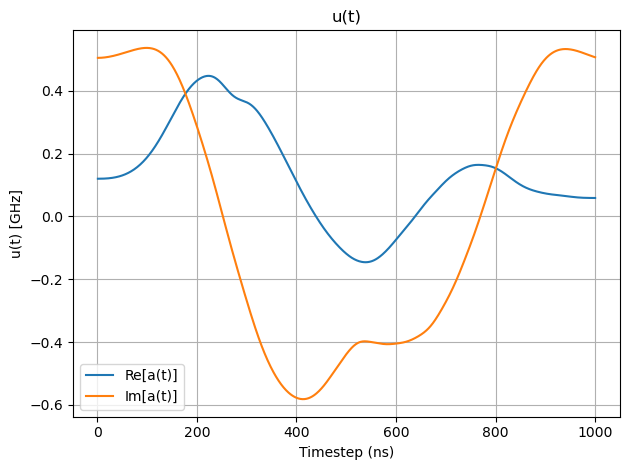

In [115]:
ts = 1:N-1
plt.xlabel("Timestep (ns)")
plt.ylabel("u(t) [GHz]")
plt.title("u(t)")
plt.plot(dt*ts, Urv, label="Re[a(t)]")
plt.plot(dt*ts, Uiv, label="Im[a(t)]")
# plot(dt*ts, Uav, label="|u(t)|")
plt.grid("on")
plt.legend()
plt.tight_layout()

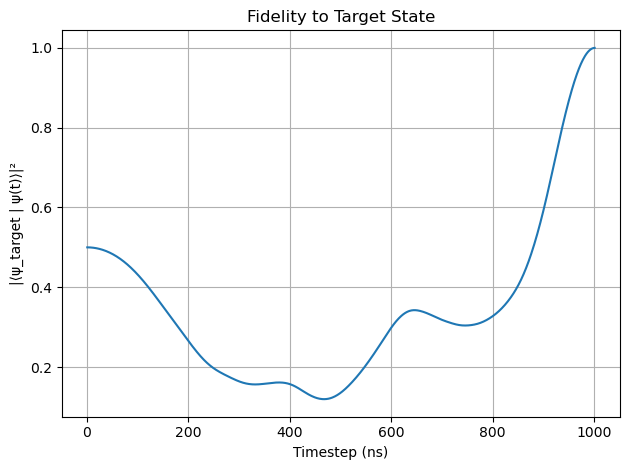

In [116]:
ts = 1:N
plt.plot(dt*ts, fidt)
plt.xlabel("Timestep (ns)")
plt.ylabel("|⟨ψ_target | ψ(t)⟩|²")
plt.title("Fidelity to Target State")
plt.grid("on")
plt.tight_layout()

# 3ns * 1.2 = pi

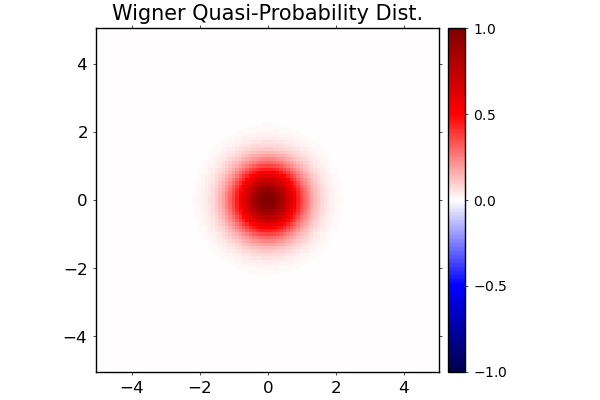

In [117]:
plot_wigner(ptrace(Xqv[1],2))

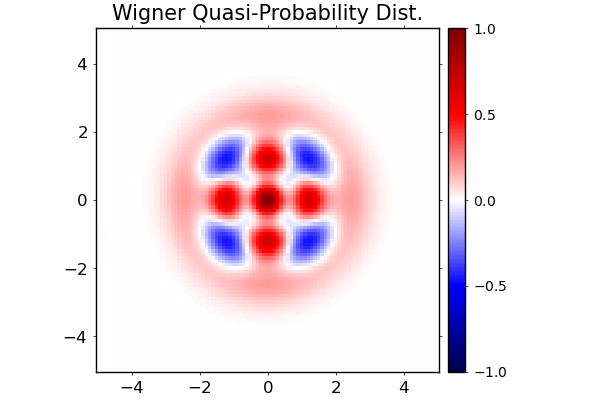

In [118]:
plot_wigner(ptrace(Xqv[end],2))

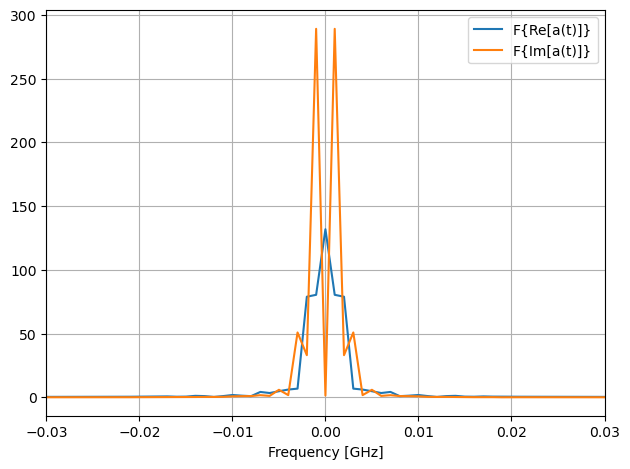

In [119]:
using FFTW
# using DSP

# Sample period
Ts = dt*N/(N-1)
# Start time 
t0 = 0 
tmax = tf
# time coordinate
t = t0:Ts:tmax


freqs = fftfreq(length(t), 1.0/Ts) |> fftshift

# real
signal = Urv
F_r = fft(signal) |> fftshift


# real
signal = Uiv
F_i = fft(signal) |> fftshift

# plots 
# time_domain = plot(t, signal)

freq_domain = plt.plot(freqs, abs.(F_r), label="F{Re[a(t)]}")
freq_domain = plt.plot(freqs, abs.(F_i), label="F{Im[a(t)]}")
plt.xlim(-.03,.03)
plt.grid("on")
plt.xlabel("Frequency [GHz]")
plt.legend()
plt.tight_layout()

# Phase Space Animations

┌ Info: Saved animation to 
│   fn = /Users/phionx/Github/mit/QControl.jl/explore/binomial/tmp.gif
└ @ Plots /Users/phionx/.julia/packages/Plots/1KWPG/src/animation.jl:114


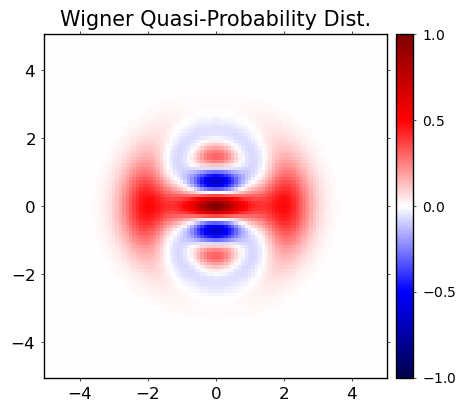

Plots.AnimatedGif("/Users/phionx/Github/mit/QControl.jl/explore/binomial/tmp.gif")
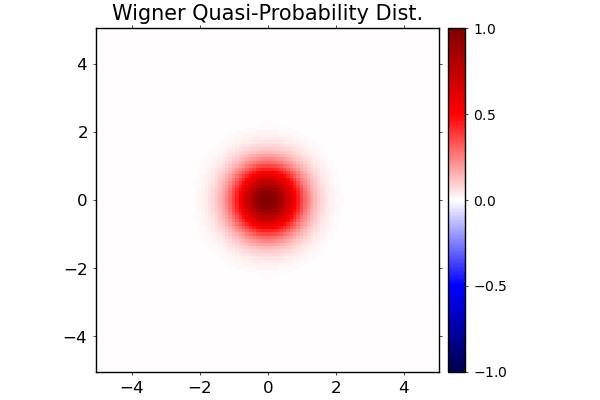

In [82]:
# animate_wigner(Xqv, trace_idx=2)

# References

[1] https://arxiv.org/pdf/1707.01060.pdf (quantum optics)

[2] https://github.com/alec-eickbusch/QOGS (quantum optimal gate synthesis)

[3] https://arxiv.org/pdf/2103.15716.pdf  (robotic quantum optimal control)

[4] https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031006 (binomial code)